#**Sourcing & Analyzing Time Series Data**

In [14]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
from datetime import datetime
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore")

###configure quandl api key to access data

In [6]:
quandl.api_config="_QpDXv-NmYQLyVZqVVpR"

##Load time series data from the server

In [16]:
data=quandl.get("FRED/CPIAUCSL")
data

,Value
Date,
1947-01-01,21.480
1947-02-01,21.620
1947-03-01,22.000
1947-04-01,22.000
1947-05-01,21.950
...,...
2021-09-01,274.214
2021-10-01,276.590
2021-11-01,278.524


## Data Exploration

In [17]:
print(data.shape)
data.columns

(901, 1)


Index(['Value'], dtype='object')

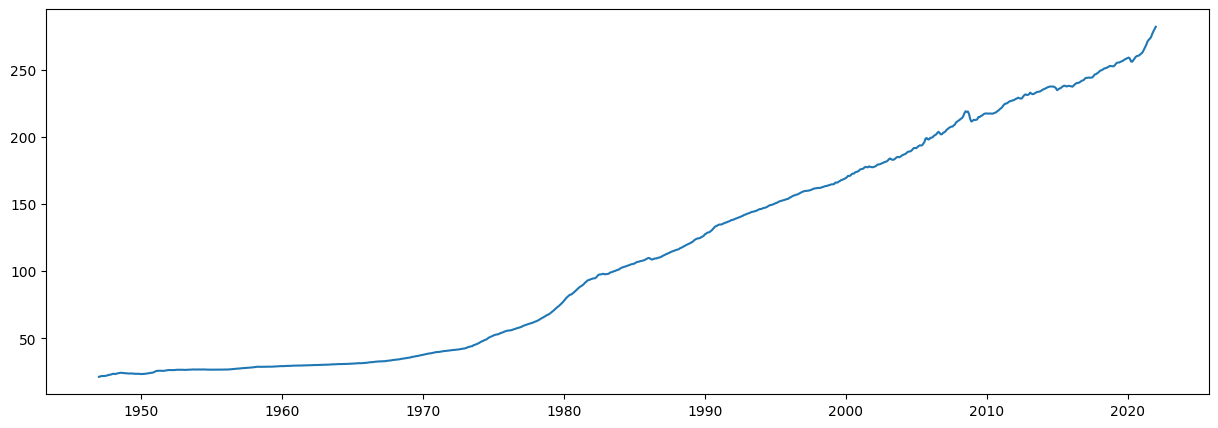

In [18]:
# Plot the data using matplotlib.
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data)


##Subsetting, wrangling, and cleaning time-series data


In [19]:
# Reset index so that you can use the "Date" column as a filter
data_2 = data.reset_index()

In [20]:
data_sub = data_2.loc[(data_2['Date'] >= '1980-01-01') & (data_2['Date'] < '2020-06-01')]

In [23]:
data_sub['datetime']=pd.to_datetime(data_sub['Date'])
data_sub = data_sub.set_index('datetime')
data_sub.drop(['Date'],axis=1, inplace=True)
data_sub.head()

,Value
datetime,
1980-01-01,78.0
1980-02-01,79.0
1980-03-01,80.1
1980-04-01,80.9
1980-05-01,81.7


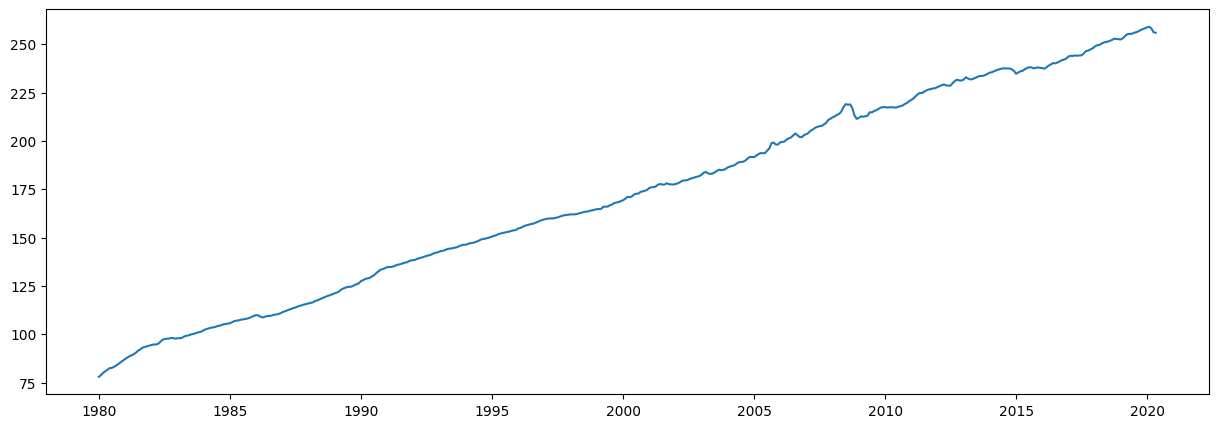

In [24]:
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

## Decomposing of the data for time-series analysis

In [25]:
# Decomposing the time series using an additive model
decomposition = sm.tsa.seasonal_decompose(x = data_sub, model='additive')

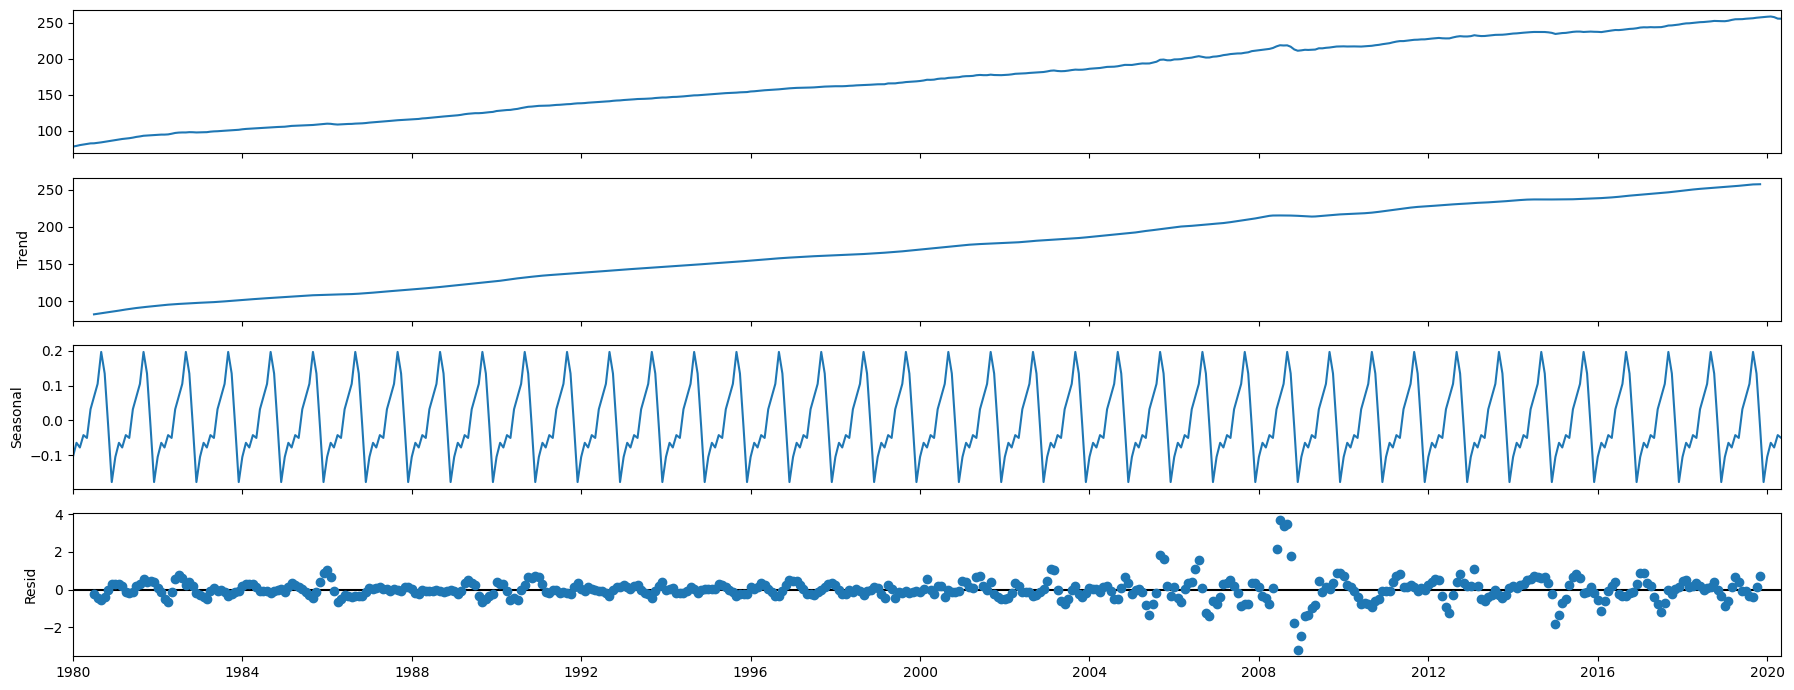

In [27]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7
# Plot the separate components
decomposition.plot()
plt.show()

The visualization above shows the decomposition of the time series data into three components: trend, seasonality, and residuals.

- **Trend:** The trend component shows the long-term direction of the data. In this case, the trend is upward, indicating that the CPI has been increasing over time.
- **Seasonality:** The seasonality component shows the repeating patterns in the data. In this case, there is a clear seasonal pattern, with the CPI being higher in the summer months and lower in the winter months.
- **Residuals:** The residuals component shows the remaining variation in the data that is not explained by the trend or seasonality.

This decomposition can be used to better understand the behavior of the time series data and to make more informed predictions about future values.

##Testing for stationarity
####Dickey-Fuller Test

In [29]:
from statsmodels.tsa.stattools import adfuller # Import the adfuller() function
# Perform the Dickey-Fuller test

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])


Dickey-Fuller Stationarity test:
Test Statistic                  -0.666323
p-value                          0.855281
Number of Lags Used             15.000000
Number of Observations Used    469.000000
Critical Value (1%)             -3.444370
Critical Value (5%)             -2.867722
Critical Value (10%)            -2.570063
dtype: float64


The Dickey-Fuller test results show that the p-value is greater than the significance level of 0.05, indicating that the null hypothesis of non-stationarity cannot be rejected. This means that the time series data is non-stationary and further differencing or transformations may be needed before it can be used for forecasting.

Additional information can be gleaned from the test results:

- The test statistic is negative, which is a good sign. It means that the time series is trending towards stationarity.
- The number of lags used is 15, which is the maximum number of lags allowed by the test. This suggests that there may be some seasonality in the data.
- The critical values show the different levels of significance for the test statistic. The 5% critical value is -2.867722, which is greater than the test statistic of -0.666323. This means that the null hypothesis of non-stationarity cannot be rejected at the 5% significance level.


Dickey-Fuller Stationarity test:
Test Statistic                  -5.391321
p-value                          0.000004
Number of Lags Used             14.000000
Number of Observations Used    469.000000
Critical Value (1%)             -3.444370
Critical Value (5%)             -2.867722
Critical Value (10%)            -2.570063
dtype: float64


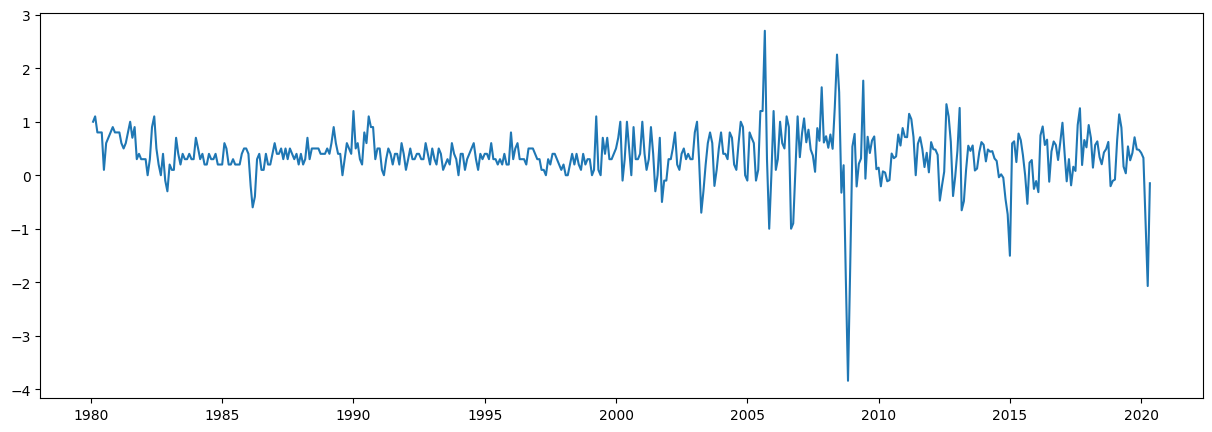

In [30]:
# First difference the data
data_sub_diff = data_sub.diff().dropna()

# Plot the differenced data
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub_diff)

# Perform the Dickey-Fuller test on the differenced data
dickey_fuller(data_sub_diff['Value'])


The Dickey-Fuller test results for the differenced data show that the p-value is now less than the significance level of 0.05, indicating that the null hypothesis of non-stationarity can be rejected. This means that the differenced time series data is stationary and can be used for forecasting.

The test statistic is now more negative, which is a further indication of stationarity. The number of lags used is still 14, which suggests that there may still be some seasonality in the data. However, the critical values show that the 5% critical value is now -2.867722, which is less than the test statistic of -5.391321. This means that the null hypothesis of non-stationarity can be rejected at the 5% significance level.

Overall, the Dickey-Fuller test results suggest that the differenced time series data is stationary and can be used for forecasting. However, it is important to note that there may still be some seasonality in the data that needs to be addressed before forecasting can be performed.

##Autocorrelations Test

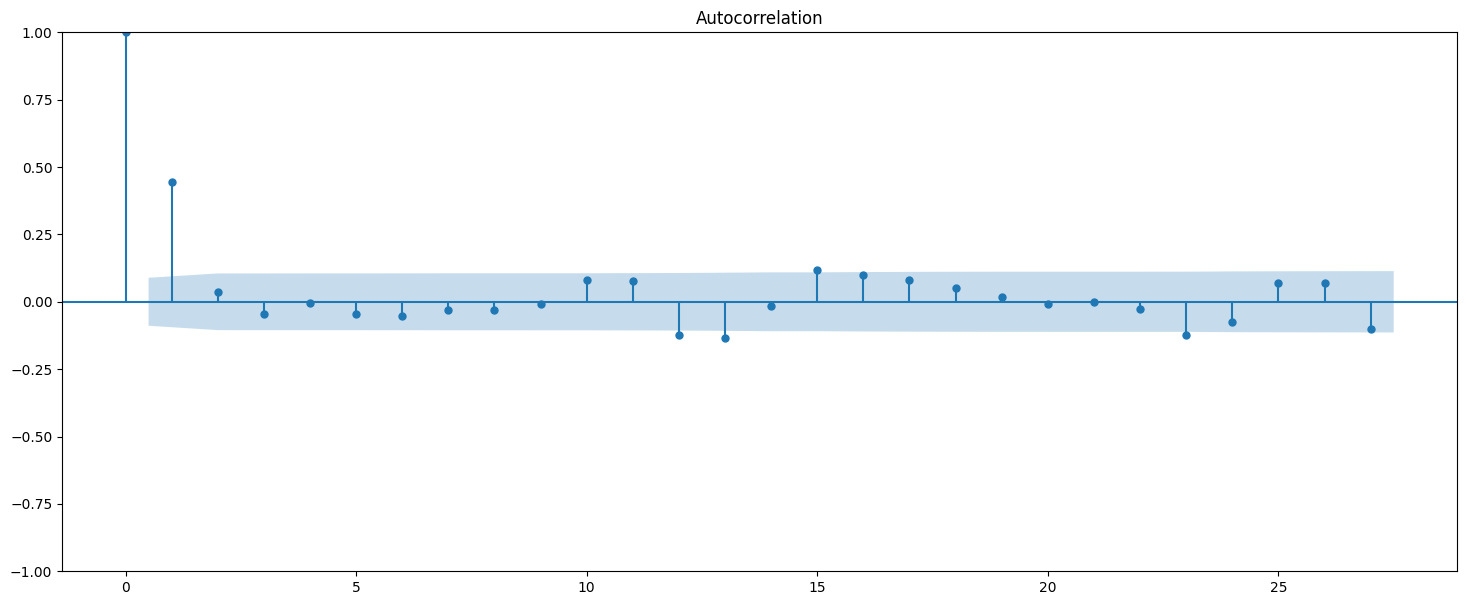

In [32]:
# Importing the autocorrelation and partial correlation plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data_sub_diff)
plt.show()

The autocorrelation plot above shows the autocorrelation coefficients for the differenced time series data. The autocorrelation coefficients are plotted against the lag values. The lag value is the number of periods that the data is shifted back in time.

The autocorrelation plot shows that there is a significant positive autocorrelation at lag 1. This means that the current value of the time series is positively correlated with the value from the previous period. There is also a significant negative autocorrelation at lag 14. This means that the current value of the time series is negatively correlated with the value from 15 periods ago.
